Welcome to the inference notebook for the Urban Sound Classification project (NAML-2024 project by Lorenzo Gentile).
This notebook lets you load trained models to make predictions on the test set. You can also plot the confusion matrix and inspect the feature of intermediate layers of the model.

In [1]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

Here we load one of the available trained models from the SAVED_MODELS_DIR directory. 
The notebook will prompt you to select the model you want to load. Along with the model, also the parameters used for loading and preprocessing the data and those used for training the model will be loaded. In this way, you can reproduce the same preprocessing steps and use a test set that is consistent with the one used for training (the model has not trained on samples from the test set).

In [2]:
SAVED_MODELS_DIR = 'saved_models/'

from scripts.model_utils import list_and_load_model

# Load a model
model, preprocess_params, training_params = list_and_load_model(SAVED_MODELS_DIR)

0: UrbanSound8K_log_mel_spectrogram_77.78
1: UrbanSound8K_log_mel_spectrogram_80.05
2: UrbanSound8K_scalogram_62.01
3: UrbanSound8K_log_mel_spectrogram-scalogram_75.27


2024-05-01 12:18:48.171727: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-01 12:18:48.171764: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-01 12:18:48.171774: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-01 12:18:48.172023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-01 12:18:48.172269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loaded model from saved_models/UrbanSound8K_log_mel_spectrogram_80.05
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 247, 64, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 247, 64, 16)       400       
                                                                 
 batch_normalization (Batch  (None, 247, 64, 16)       64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 247, 64, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 82, 64, 16)        0         
 D)                                                              
                                                         

In this cell we unpack and print the preprocessing parameters and the training parameters, which were saved in JSON format in the assets directory of the model.

In [9]:
from pprint import pprint

print("Preprocess parameters:")
pprint(preprocess_params, sort_dicts=False)

print("\nTraining parameters:")
pprint(training_params, sort_dicts=False)

Preprocess parameters:
{'DATASET_NAME': 'UrbanSound8K',
 'URBANSOUND8K_TESTFOLD': 10,
 'ESC_TESTFOLD': 5,
 'WHOLE_ESC_50': False,
 'TARGET_SR': 16000,
 'DATA_AUGMENTATION': False,
 'AUGMENTATION_FACTOR': 0.5,
 'ADD_NOISE': False,
 'NOISE_TYPES': ['white', 'pink'],
 'NOISE_LEVELS': [0.025, 0.025],
 'NOISE_PROBS': [0.5, 0.5],
 'TIME_SHIFT': False,
 'MAX_SHIFT': 1.5,
 'TIME_STRETCH': True,
 'STRETCH_RANGE': [0.8, 1.2],
 'PITCH_SHIFT': False,
 'PITCH_RANGE': [-2, 2],
 '2D_TRANSFORMS': ['log_mel_spectrogram'],
 '1D_TRANSFORMS': [],
 'FRAME_LENGTH': 1024,
 'FRAME_STEP': 256,
 'FFT_LENGTH': 1024,
 'NUM_MEL_BINS': 64,
 'NUM_MFCCS': 64,
 'NUM_SCALES': 64,
 'CWT_WAVELET': 'morl',
 'DWT_WAVELET': 'db1',
 'NORMALIZATION': 'mean_std'}

Training parameters:
{'TRAIN_SPLIT': 0.9,
 'BATCH_SIZE': 16,
 'SHUFFLE_BUFFER_PERCENT': 1,
 'NUM_EPOCHS': 50,
 'LEARNING_RATE': 0.003,
 'EARLY_STOPPING_PATIENCE': 4,
 'DROPOUT_RATE': 0.2}


In the next cell, we load the dataset on which the model was trained and we apply the exact same preprocessing steps. Then we split the dataset to obtain the test set (which thanks to the reproducibility of the preprocessing steps is consistent with the one used for training).

In [11]:
from scripts.dataset_loading import load_dataset
from scripts.audio_preprocessing import apply_padding, transform_normalize_dataset

# Load and process audio files with same configuration

batch_size = training_params['BATCH_SIZE']

_, test_ds, class_names = load_dataset(preprocess_params)

test_ds = apply_padding(test_ds, preprocess_params)
test_ds = transform_normalize_dataset(test_ds, preprocess_params)
test_ds = test_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [12]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

2024-05-01 12:22:08.723474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 17s 251ms/step - loss: 0.7353 - accuracy: 0.8005


In this cell, you can plot the confusion matrix of the model on the test set.

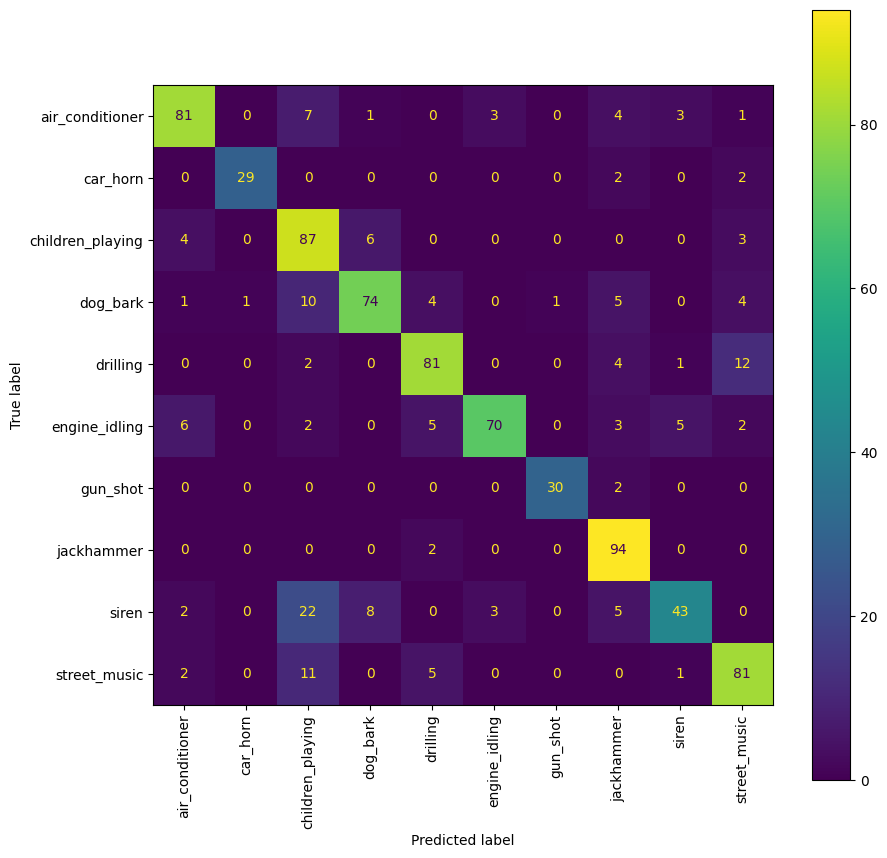

In [13]:
from scripts.model_utils import print_confusion_matrix

# Print the confusion matrix
print_confusion_matrix(model, test_ds, class_names)

In this cell, you can inspect the feature maps of the intermediate layers of the model. You can select the layer you want to inspect by setting the `LAYER_INDEX` variable. The feature maps of the selected layer will be displayed for a random sample of the test set.

In [ ]:
from scripts.model_utils import plot_feature_maps

# Visualize the feature maps of a specific layer
LAYER_INDEX = 16 # Choose the layer whose activations you want to visualize

tf.keras.utils.set_random_seed(67)
plot_feature_maps(model, LAYER_INDEX, test_ds, class_names)

Finally, in this cell, you can visualize the filters of the convolutional layers of the model. Filters of all convolutional layers are displayed.

In [ ]:
from scripts.model_utils import plot_conv_weights

# Visualize the convolutional weights
plot_conv_weights(model)